## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.Softplus(),
            nn.Dropout(),
            nn.Linear(num_classes, num_classes),
            nn.LogSoftmax(),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
       BatchNorm1d-3                   [-1, 10]              20
          Softplus-4                   [-1, 10]               0
           Dropout-5                   [-1, 10]               0
            Linear-6                   [-1, 10]             110
        LogSoftmax-7                   [-1, 10]               0
Total params: 7,980
Trainable params: 7,980
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=10e-3)
loss_func = nn.NLLLoss()

In [10]:
def train_net(model, train_loader, test_loader, 
                loss_function, opt, n_epochs):
  train_loss = []
  test_loss = []
  accuracy = []

  for i in range(n_epochs):
    local_train_loss = []
    local_test_loss =[]

    model.train(True) 
    for x_batch, y_batch in train_loader:
        opt.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
    
        predictions = model(x_batch)
        loss = loss_function(predictions, y_batch)
        
        loss.backward()
        opt.step()
            
        local_train_loss.append(loss.item())

    model.train(False) 
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
                
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch)

            y_pred = predictions.max(1)[1].data
                
            local_test_loss.append(loss.item())
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    
    train_loss.append(np.mean(local_train_loss))
    test_loss.append(np.mean(local_test_loss))
        
  print(f"\test accuracy: {accuracy[-1]:.3f}")
  return train_loss, test_loss

In [11]:
n_epochs = 20

torch_train_loss, torch_test_loss = train_net(model, train_loader,
                                             test_loader, loss_func,
                                             opt, n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


	est accuracy: 0.812


In [12]:
def plot_loss(overfit_train_loss, overfit_test_loss):
  plt.figure(figsize=(19, 9))

  plt.title("Loss")
  plt.plot(overfit_train_loss, label='train')
  plt.plot(overfit_test_loss, label='test')
  plt.ylabel("loss")
  plt.xlabel('batch amt')
  plt.legend(fontsize=12)
  plt.show()

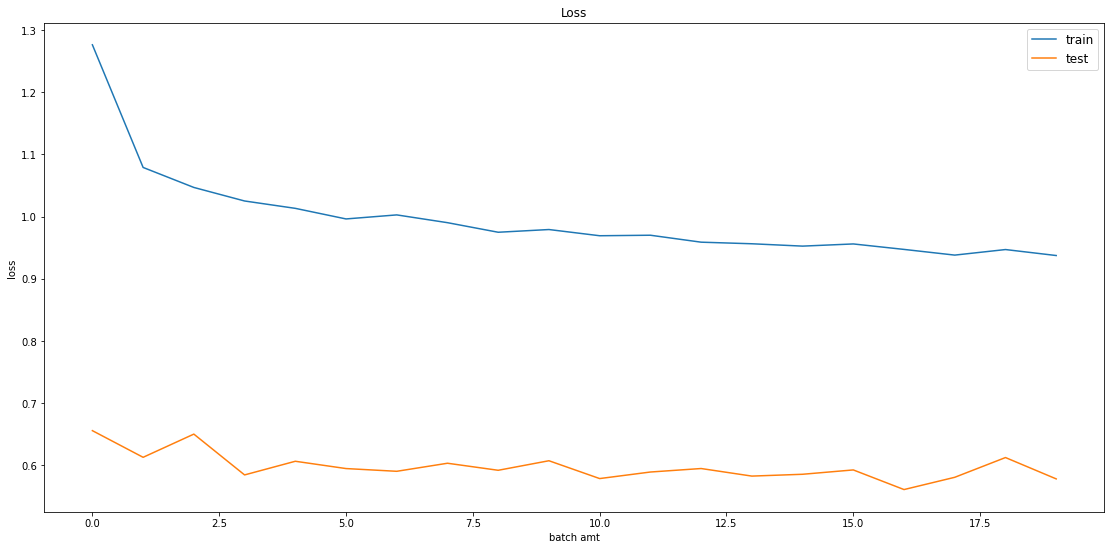

In [13]:
plot_loss(torch_train_loss, torch_test_loss)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [14]:
new_train_dataset, _ = torch.utils.data.dataset.random_split(fmnist_dataset_train, [10000, 50000])

new_train_loader = torch.utils.data.DataLoader(new_train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [15]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 400),
            nn.LeakyReLU(),
            nn.Linear(400, num_classes),
            nn.LeakyReLU(),
            nn.Linear(num_classes, 400),
            nn.LeakyReLU(),
            nn.Linear(400, num_classes),
            nn.LogSoftmax(),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
         LeakyReLU-3                  [-1, 400]               0
            Linear-4                   [-1, 10]           4,010
         LeakyReLU-5                   [-1, 10]               0
            Linear-6                  [-1, 400]           4,400
         LeakyReLU-7                  [-1, 400]               0
            Linear-8                   [-1, 10]           4,010
        LogSoftmax-9                   [-1, 10]               0
Total params: 326,420
Trainable params: 326,420
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.25
Estimated Total Size (MB): 1.27
-------------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [17]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=10e-3)
loss_func = nn.NLLLoss()

In [18]:
n_epochs = 120

overfit_train_loss, overfit_test_loss = train_net(model, new_train_loader,
                                             test_loader, loss_func,
                                             opt, n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


	est accuracy: 0.938


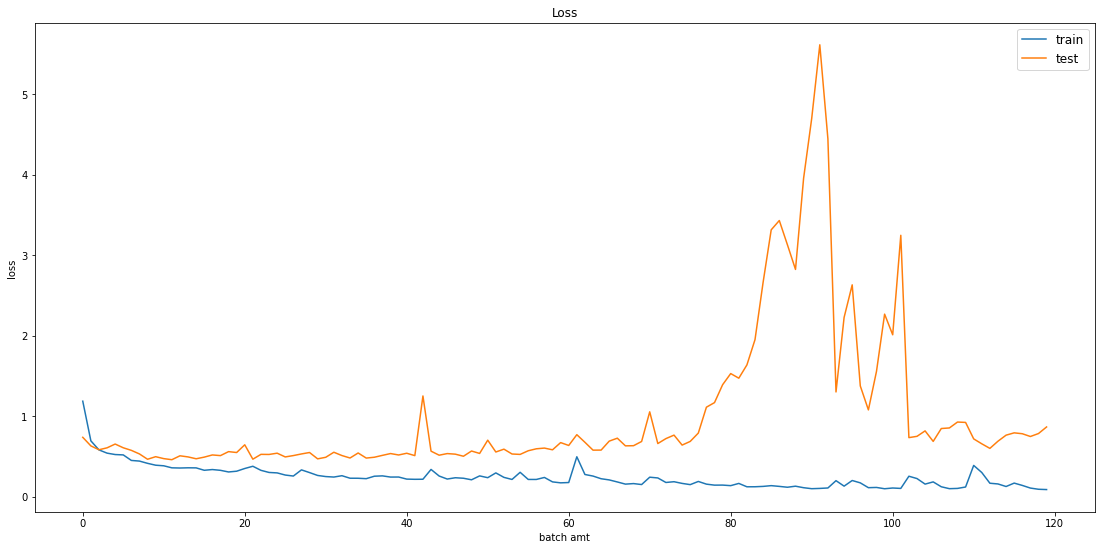

In [19]:
plot_loss(overfit_train_loss, overfit_test_loss)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [20]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(400, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(num_classes, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(400, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(num_classes, num_classes),
            nn.LogSoftmax(),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [21]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
       BatchNorm1d-3                  [-1, 400]             800
         LeakyReLU-4                  [-1, 400]               0
           Dropout-5                  [-1, 400]               0
            Linear-6                   [-1, 10]           4,010
       BatchNorm1d-7                   [-1, 10]              20
         LeakyReLU-8                   [-1, 10]               0
           Dropout-9                   [-1, 10]               0
           Linear-10                  [-1, 400]           4,400
      BatchNorm1d-11                  [-1, 400]             800
        LeakyReLU-12                  [-1, 400]               0
          Dropout-13                  [-1, 400]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [22]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=10e-3)
loss_func = nn.NLLLoss()


In [23]:
n_epochs = 120

fixed_train_loss, fixed_test_loss = train_net(model, new_train_loader,
                                             test_loader, loss_func,
                                             opt, n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


	est accuracy: 0.562


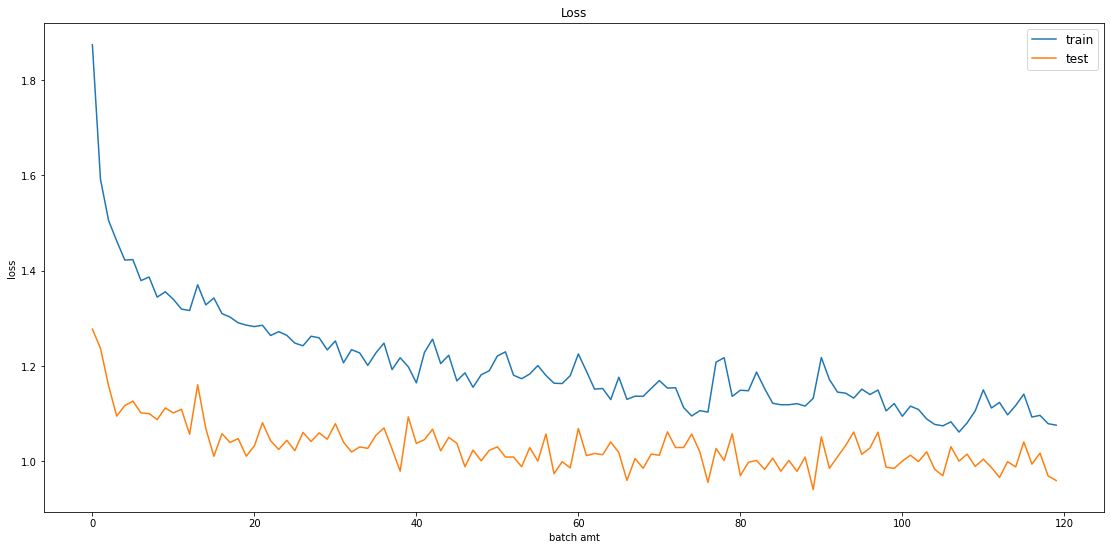

In [24]:
plot_loss(fixed_train_loss, fixed_test_loss)

### Conclusions:
At first I trained a usual neural network using algorithm from the previous part of the Lab.

Then I tried to overfit it excluding dropout and Adam optimizer. Also increasing the number of epochs can cause overfitting; I also decreased the size of train set; and on the plot we can see that test loss is above train loss with HUUUGE dropouts

After that I applied Adam opt, nn.dropout and the plot now looks much nicer, without agressive dropouts and more stable